# Data Exploration

In [19]:
import polars as pl 
import pandas as pd
import numpy as np
from pathlib import Path
import datetime
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA

In [26]:
script_dir = Path(Path.cwd()).parent
df = pl.read_parquet(script_dir / 'data' / 'synthetic_prices.parquet')
df = df.filter(pl.col('tradingDay') > datetime.date(2015,12,31))
df = df.group_by("tradingDay").first().sort("tradingDay")

## Pair-wise Analysis

Before moving to PCA and multi-maturity portfolios, I want to sanity-check the simplest possible relative-value structure: hedging the 1-month VIX future with the 3-month future and studying the residual. This helps me understand what kind of object I am trying to isolate.

### Residual Analysis

Regresses 1M returns (y) on 3M returns (x).

Computes:

* beta: the linear sensitivity of 1M to 3M
* alpha: intercept (small, near zero)

Constructs the residual return:
“What remains of 1M after removing the part explained by 3M”

* I'm stripping out the dominant level/parallel-move component shared by both maturities.
* What remains is curvature / relative-maturity behavior.


In [3]:
df_ret = (
    df
    .with_columns([
        pl.col("px_30d").log().diff().alias("r_1m"),
        pl.col("px_90d").log().diff().alias("r_3m"),
    ])
    .drop_nulls()
)

x = df_ret["r_3m"].to_numpy()
y = df_ret["r_1m"].to_numpy()

beta = np.cov(y, x)[0, 1] / np.var(x)
alpha = y.mean() - beta * x.mean()

residual = y - (alpha + beta * x)
df_ret = df_ret.with_columns(
    pl.Series("residual", residual)
)
var_ratio = np.var(residual) / np.var(y)

print(f"Variance ratio (residual / 1M return): {var_ratio:.4f}")


Variance ratio (residual / 1M return): 0.0902


This pair captures the dominant risk factor extremely well.

The residual is a low-variance object, good to isolate carry/relative value rather than level risk.

In [4]:
res_mean = residual.mean()
res_std = residual.std()
res_skew = skew(residual)
res_kurt = kurtosis(residual, fisher=True)

print(f"Mean:      {res_mean:.6e}")
print(f"Std:       {res_std:.6e}")
print(f"Skew:      {res_skew:.3f}")
print(f"Kurtosis:  {res_kurt:.3f}")

Mean:      4.232391e-19
Std:       1.343470e-02
Skew:      -0.710
Kurtosis:  33.862


Mean ≈ 0
The residual is properly centered. There is no obvious drift coming from regression mis-specification.

Std ≈ 1.34% (daily)
This is small relative to raw VIX futures returns, consistent with the variance ratio result.

Skew ≈ −0.71
The residual has left-tail asymmetry: negative shocks tend to be larger than positive ones.

Kurtosis ≈ 33.9 (Fisher)
Extremely fat-tailed distribution. Large residual moves occur much more often than a Gaussian benchmark would imply.

This combination (low variance, high kurtosis) is characteristic of:

A series that is usually quiet

Occasionally subject to sharp dislocations

In [5]:
lag1_autocorr = np.corrcoef(residual[1:], residual[:-1])[0, 1]

print(f"Lag-1 autocorrelation: {lag1_autocorr:.4f}")

Lag-1 autocorrelation: -0.0441


The residual is essentially serially uncorrelated at the daily horizon.

The small negative value suggests very mild short-term mean reversion, but economically it is close to zero.

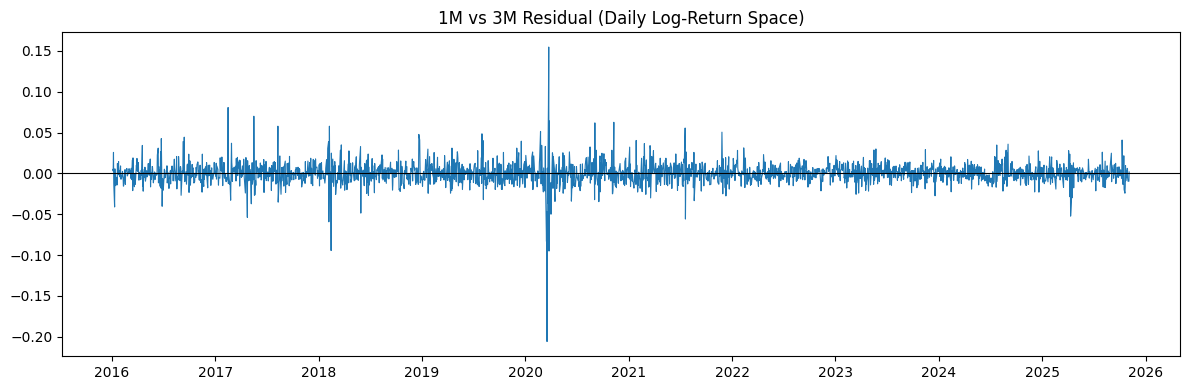

In [6]:
plt.figure(figsize=(12, 4))
plt.plot(df_ret["tradingDay"], residual, linewidth=0.8)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("1M vs 3M Residual (Daily Log-Return Space)")
plt.tight_layout()
plt.show()

### Conclusions

Relative-maturity hedging works
Even a simple 1M–3M hedge removes most of the risk.

The residual is not noise
It has a distinct distribution with meaningful tail behavior.

This motivates PCA
If a single pair already isolates a clean residual, a multi-maturity PCA framework should generalize this idea more efficiently across the entire curve.

### VIX Bucket Analysis

In [7]:
df_ret = df_ret.with_columns(
    pl.col("VIX")
    .qcut(5, labels=[f"Q{i+1}" for i in range(5)])
    .alias("vix_bucket")
)

def lag1_autocorr(x):
    return np.corrcoef(x[1:], x[:-1])[0, 1] if len(x) > 1 else np.nan

vix_stats = (
    df_ret
    .group_by("vix_bucket")
    .agg([
        pl.len().alias("n_obs"),
        pl.col("residual").mean().alias("mean"),
        pl.col("residual").std().alias("std"),
        pl.col("residual").map_elements(skew).alias("skew"),
        pl.col("residual").map_elements(lambda x: kurtosis(x, fisher=True)).alias("kurtosis"),
        pl.col("residual").map_elements(lag1_autocorr).alias("lag1_autocorr"),
    ])
    .sort("vix_bucket")
)
vix_stats

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


vix_bucket,n_obs,mean,std,skew,kurtosis,lag1_autocorr
cat,u32,f64,f64,f64,f64,f64
"""Q1""",499,-0.000493,0.010904,0.55466,7.227807,-0.080007
"""Q2""",498,0.000427,0.009824,0.030322,1.514587,-0.111716
"""Q3""",499,0.000445,0.011415,1.147863,4.542836,-0.043544
"""Q4""",497,-0.000045,0.012338,-0.669289,7.970461,-0.103314
"""Q5""",499,-0.000333,0.020132,-1.166387,30.103383,-0.002951


Means are very close to zero in all buckets There is no obvious unconditional drift in the residual that depends on the VIX level.

Volatility increases with VIX The residual’s standard deviation is lowest in Q1–Q3 and rises meaningfully in Q5. This tells me that even after hedging out level moves, relative-maturity dynamics become noisier in high-volatility environments.

Skew changes sign across regimes

Lower VIX buckets (Q1–Q3) tend to have positive skew.

Higher VIX buckets (Q4–Q5) exhibit negative skew.

This indicates an asymmetry: downside tail risk in the residual is more pronounced when volatility is elevated.

Kurtosis explodes in the highest VIX bucket Q5 has extremely high kurtosis relative to the other buckets. This confirms that the most extreme residual moves occur disproportionately in high-VIX regimes.

Lag-1 autocorrelation is near zero everywhere There is no strong evidence of serial dependence in any VIX regime. Whatever structure exists is cross-sectional / structural, not time-series momentum or mean reversion.


### Curve Slope Buckets

In [8]:
df_ret = df_ret.with_columns(
    (pl.col("px_90d") - pl.col("px_30d")).alias("slope")
)

df_ret = df_ret.with_columns(
    pl.col("slope")
    .qcut(5, labels=[f"Q{i+1}" for i in range(5)])
    .alias("slope_bucket")
)
slope_stats = (
    df_ret
    .group_by("slope_bucket")
    .agg([
        pl.len().alias("n_obs"),
        pl.col("residual").mean().alias("mean"),
        pl.col("residual").std().alias("std"),
        pl.col("residual").map_elements(skew).alias("skew"),
        pl.col("residual").map_elements(lambda x: kurtosis(x, fisher=True)).alias("kurtosis"),
        pl.col("residual").map_elements(lag1_autocorr).alias("lag1_autocorr"),
    ])
    .sort("slope_bucket")
)
slope_stats

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


slope_bucket,n_obs,mean,std,skew,kurtosis,lag1_autocorr
cat,u32,f64,f64,f64,f64,f64
"""Q1""",499,-0.000366,0.021099,-1.135762,25.366707,0.019401
"""Q2""",498,0.000848,0.011595,0.830244,4.852936,-0.054085
"""Q3""",498,0.000706,0.009699,-0.006922,2.429787,-0.054274
"""Q4""",498,-0.000195,0.011298,0.650012,6.345588,-0.034327
"""Q5""",499,-0.000991,0.01001,0.149036,0.744416,0.017845


Means remain close to zero across all buckets Just like with VIX, there is no obvious unconditional directional bias tied purely to slope.

Residual volatility is highest in extreme slope regimes Both very flat/backwardated curves (Q1) and very steep curves (Q5) show elevated residual volatility relative to the middle buckets.

Skew is most negative in flat-curve regimes (Q1) This suggests that when the curve is flat or inverted, negative residual shocks tend to be larger than positive ones.

Kurtosis is highest in the flattest slope bucket Q1 shows extremely high kurtosis, indicating that the worst tail events for this residual tend to occur when the curve is flat or stressed.

Lag-1 autocorrelation remains small As with VIX buckets, there is no strong serial structure emerging from slope conditioning.


## PCA based Analysis

a) Rolling window PCA
* PCA is fit on a rolling window (default 90 days)
* Ensures loadings adapt slowly to regime changes
* Avoids look-ahead bias

b) Standardized returns

* Within each window:
* Each maturity’s returns are z-scored
* PCA is done in correlation space, not covariance space

This ensures:
* No maturity dominates just because it’s more volatile
* Loadings reflect structure, not scale

c) Anchoring the Front month 
* It avoids arbitrary sign flips in PCA eigenvectors
* It ensures the strategy always expresses itself as:
> short front / long back (or vice versa)


In [9]:
script_dir = Path(Path.cwd()).parent
df = pl.read_parquet(script_dir / 'data' / 'synthetic_prices.parquet')
df = df.filter(pl.col('tradingDay') > datetime.date(2015,12,31))
df = df.group_by("tradingDay").first().sort("tradingDay")
df = df.filter(pl.col('tradingDay') > datetime.date(2015,12,31))

In [10]:
COL_DATE = "tradingDay"
PX_COLS = ["px_30d","px_60d","px_90d","px_120d","px_150d","px_180d"]

def compute_log_returns(df: pl.DataFrame) -> pl.DataFrame:
    return (
        df.sort(COL_DATE)
          .with_columns([pl.col(c).log().diff().alias(f"r_{c}") for c in PX_COLS])
          .drop_nulls()
    )

def add_carry_proxies(df_ret: pl.DataFrame) -> pl.DataFrame:
    """
    Local slope between adjacent maturities, normalized by price and time.
    * A per-maturity estimate of daily roll-down pressure
    * Signed in a way that matches P&L intuition (contango vs backwardation)
    """
    # carries computed from price levels (need levels present in df_ret too)
    # assumes df_ret still has px_* columns
    return df_ret.with_columns([
        (((pl.col("px_30d") - pl.col("px_60d")) / pl.col("px_30d")) / 30.0).alias("carry_30d"),
        (((pl.col("px_60d") - pl.col("px_90d")) / pl.col("px_60d")) / 30.0).alias("carry_60d"),
        (((pl.col("px_90d") - pl.col("px_120d")) / pl.col("px_90d")) / 30.0).alias("carry_90d"),
        (((pl.col("px_120d") - pl.col("px_150d")) / pl.col("px_120d")) / 30.0).alias("carry_120d"),
        (((pl.col("px_150d") - pl.col("px_180d")) / pl.col("px_150d")) / 30.0).alias("carry_150d"),
        # no 210d: approximate roll-down toward 150d
        (((pl.col("px_180d") - pl.col("px_150d")) / pl.col("px_180d")) / 30.0).alias("carry_180d"),
    ])

def rolling_pca_weights_min_norm(
    df_ret: pl.DataFrame,
    window: int = 90,
    rebalance_every: int = 5,
    anchor_w30: float = -1.0
) -> pl.DataFrame:
    """
    Rolling PCA on standardized returns. Construct PC1-neutral weights using:
      w30 fixed to anchor_w30,
      w_rest = k * e1_rest, with k chosen so that w·e1 = 0.
    Rebalance every `rebalance_every` rows; forward-fill weights between rebalances.
    """
    r_cols = [f"r_{c}" for c in PX_COLS]
    R = df_ret.select(r_cols).to_numpy()
    n = R.shape[0]

    W = np.full((n, len(PX_COLS)), np.nan, dtype=float)

    for t in range(window, n):
        if (t - window) % rebalance_every != 0:
            continue

        X = R[t-window:t, :]

        # standardize columns (z-score) within window
        mu = np.nanmean(X, axis=0)
        sd = np.nanstd(X, axis=0, ddof=0)
        sd = np.where(sd == 0, 1.0, sd)
        Xz = (X - mu) / sd

        pca = PCA(n_components=len(PX_COLS))
        pca.fit(Xz)

        e1 = pca.components_[0]  # PC1 loadings in standardized space

        # anchor 30d weight
        w = np.zeros(len(PX_COLS))
        w[0] = anchor_w30

        e1_30 = e1[0]
        e1_rest = e1[1:]

        denom = float(np.dot(e1_rest, e1_rest))
        if denom == 0:
            # fallback: if degenerate, keep only anchor (shouldn't happen in practice)
            W[t, :] = w
            continue

        # choose w_rest parallel to e1_rest (minimum-norm solution) to satisfy neutrality
        k = -(e1_30 * w[0]) / denom
        w[1:] = k * e1_rest

        W[t, :] = w

    # forward fill weights
    for i in range(len(PX_COLS)):
        last = np.nan
        for t in range(n):
            if not np.isnan(W[t, i]):
                last = W[t, i]
            else:
                W[t, i] = last

    # attach weights
    out = df_ret.with_columns([
        pl.Series(f"w_{PX_COLS[i]}", W[:, i]) for i in range(len(PX_COLS))
    ])
    return out

def add_daily_portfolio_attribution(df_w: pl.DataFrame) -> pl.DataFrame:
    r_cols = [f"r_{c}" for c in PX_COLS]
    w_cols = [f"w_{c}" for c in PX_COLS]
    carry_cols = ["carry_30d","carry_60d","carry_90d","carry_120d","carry_150d","carry_180d"]

    # total = sum w_i * r_i
    # carry = sum w_i * carry_i
    total_expr = sum(pl.col(w_cols[i]) * pl.col(r_cols[i]) for i in range(len(PX_COLS)))
    carry_expr = sum(pl.col(w_cols[i]) * pl.col(carry_cols[i]) for i in range(len(PX_COLS)))

    return df_w.with_columns([
        total_expr.alias("port_total"),
        carry_expr.alias("port_carry"),
        (total_expr - carry_expr).alias("port_shock"),
    ])

In [24]:
df_ret = compute_log_returns(df)              # keeps px_* plus adds r_px_*
df_ret = add_carry_proxies(df_ret)            # adds carry_*
df_w   = rolling_pca_weights_min_norm(df_ret) # adds w_*
df_attr= add_daily_portfolio_attribution(df_w)# adds port_total/carry/shock
df_ret.write_parquet(script_dir / 'data' / 'df_ret.parquet')
df_w.write_parquet(script_dir / 'data' / 'df_w.parquet')
df_attr.write_parquet(script_dir / 'data' / 'df_attr.parquet')

I construct weights such that:

* Portfolio is orthogonal to PC1
* Remaining weights are parallel to PC1 loadings
* Total exposure is the smallest possible that satisfies neutrality

This gives:
* A clean hedge against level moves
* Minimal leverage
* Maximum stability across time

Weights are only recomputed every rebalance_every days and forward-filled in between.

* Reduces turnover
* Better approximates real trading
* Avoids noise from daily PCA churn

### PCA Stability Analysis

If PC1 is unstable—rotating rapidly or changing economic meaning—then any strategy built on it would be fragile, regardless of backtested Sharpe.

#### 1. Setup and inputs

* The six fixed-maturity VIX price series (30d → 180d)
* Their corresponding log-return columns
* A rolling window of 90 trading days
* Rebalancing every 5 trading days

#### 2. Rolling PCA construction

For each rebalance date:

* Take the trailing 90 days of returns
* standardize each maturity’s returns within the window
* fit a full PCA (all components retained)

This ensures that:

* PCA is performed in return space
* Results are not dominated by maturity-specific volatility
* Loadings are comparable through time

#### 3. Tracking PC1 explained variance

* How much of the total return variance is explained by the first principal component
* PC1 explains ~97% of total variance

#### 4. Eigenvector rotation (stability test)

* The angle between today’s PC1 eigenvector and the previous rebalance’s eigenvector
* Rotation ≈ 0 → PC1 direction is stable
* No evidence of abrupt eigenvector flips
* PC1 has a persistent economic meaning

#### 5. Inspecting PC1 loadings across maturities

What I am looking for:

* Smooth, monotonic structure
* Similar magnitudes across maturities
* No sign of curvature or sign changes
  
This confirms:

* PC1 is a pure parallel shift
* It is not slope or curvature masquerading as level
* Neutralizing PC1 is economically meaning

#### 6. Why this matters before trading 
* PC1 exists and dominates variance
* PC1 is stable through time
* PC1 loadings are interpretable and consistent
* PCA-based hedging is not fragile

In [28]:
R_COLS  = [f"r_{c}" for c in PX_COLS]

WINDOW = 90
REBALANCE_EVERY = 5

dates = df_ret["tradingDay"].to_pandas()
R = df_ret.select(R_COLS).to_numpy()

records = []

prev_e1 = None

for t in range(WINDOW, len(R)):
    if (t - WINDOW) % REBALANCE_EVERY != 0:
        continue

    X = R[t-WINDOW:t]

    # standardize in-window
    mu = X.mean(axis=0)
    sd = X.std(axis=0)
    sd[sd == 0] = 1.0
    Xz = (X - mu) / sd

    pca = PCA(n_components=len(PX_COLS))
    pca.fit(Xz)

    e1 = pca.components_[0]
    pc1_var = pca.explained_variance_ratio_[0]

    # eigenvector rotation
    rotation = np.nan
    if prev_e1 is not None:
        cos_angle = np.clip(np.dot(e1, prev_e1), -1.0, 1.0)
        rotation = np.arccos(cos_angle)

    prev_e1 = e1.copy()

    rec = {
        "date": dates.iloc[t],
        "pc1_var": pc1_var,
        "rotation": rotation,
    }

    # store loadings
    for i, c in enumerate(PX_COLS):
        rec[f"pc1_{c}"] = e1[i]

    records.append(rec)

diag = pd.DataFrame(records).set_index("date")
diag.to_parquet(script_dir / 'data' / 'diag.parquet')

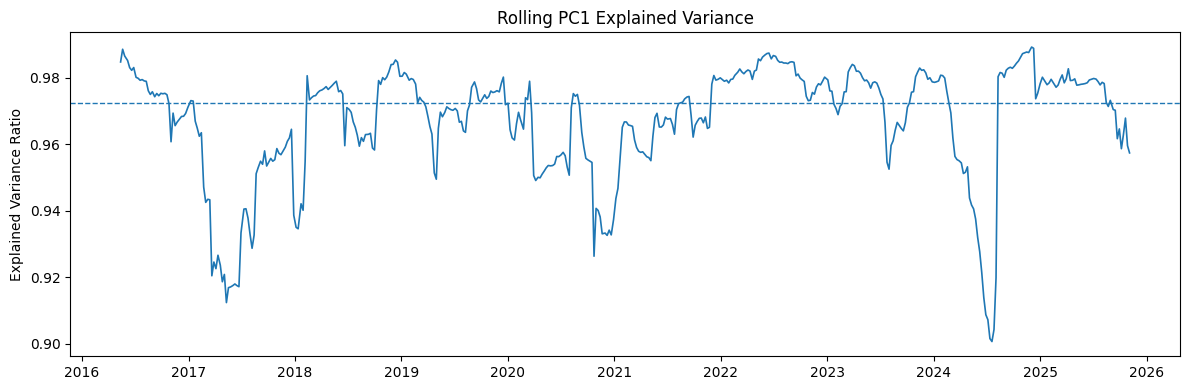

In [14]:
plt.figure(figsize=(12,4))
plt.plot(diag.index, diag["pc1_var"], linewidth=1.2)
plt.axhline(diag["pc1_var"].median(), linestyle="--", linewidth=1)
plt.title("Rolling PC1 Explained Variance")
plt.ylabel("Explained Variance Ratio")
plt.tight_layout()
plt.show()

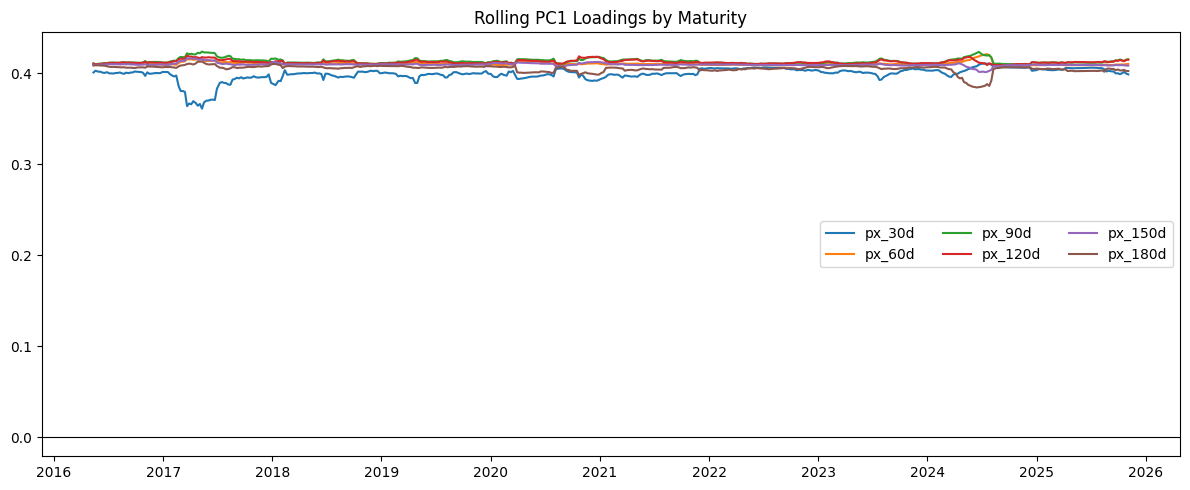

In [15]:
plt.figure(figsize=(12,5))
for c in PX_COLS:
    plt.plot(diag.index, diag[f"pc1_{c}"], label=c)

plt.axhline(0, color="black", linewidth=0.8)
plt.title("Rolling PC1 Loadings by Maturity")
plt.legend(ncol=3)
plt.tight_layout()
plt.show()


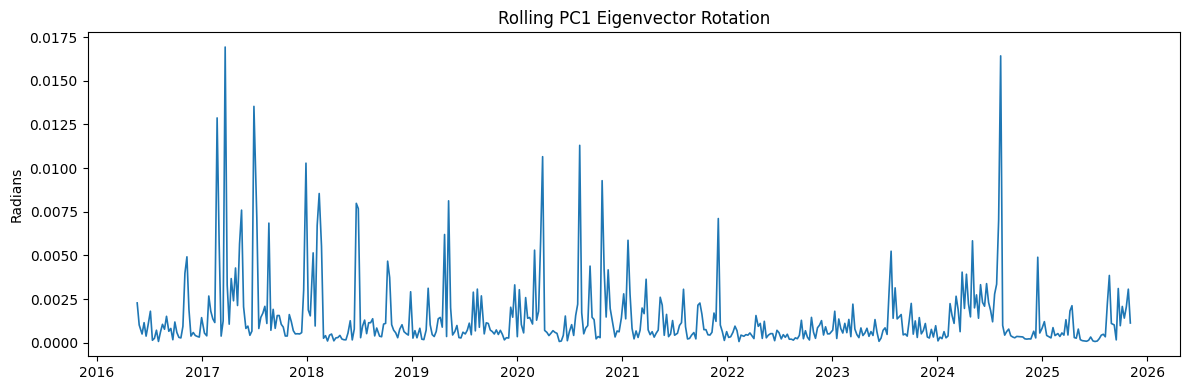

In [16]:
plt.figure(figsize=(12,4))
plt.plot(diag.index, diag["rotation"], linewidth=1.2)
plt.title("Rolling PC1 Eigenvector Rotation")
plt.ylabel("Radians")
plt.tight_layout()
plt.show()


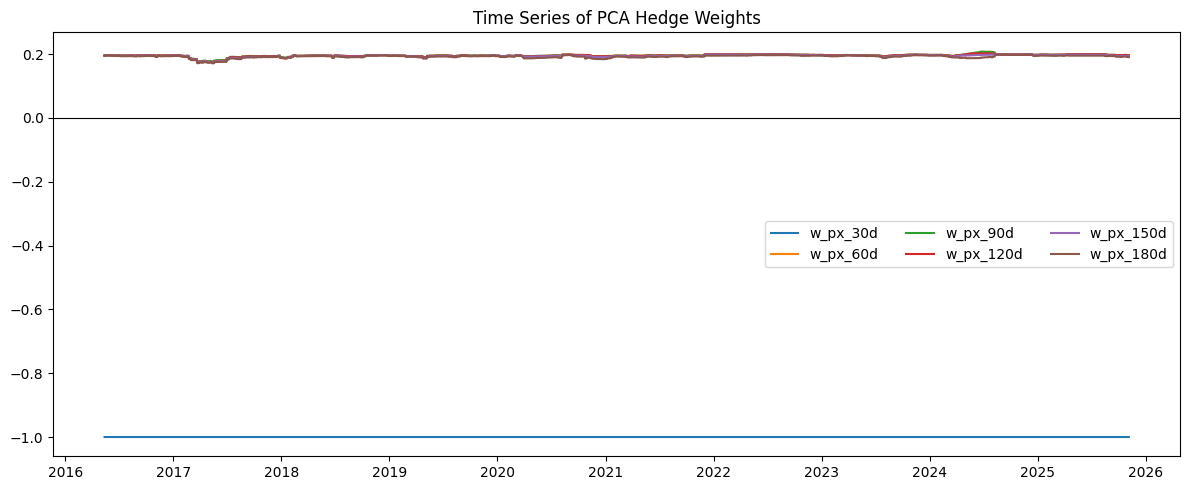

In [17]:
W_COLS = [f"w_{c}" for c in PX_COLS]

df_w = df_w.select(["tradingDay"] + W_COLS).to_pandas().set_index("tradingDay")
plt.figure(figsize=(12,5))
for c in W_COLS:
    plt.plot(df_w.index, df_w[c], label=c)

plt.axhline(0, color="black", linewidth=0.8)
plt.title("Time Series of PCA Hedge Weights")
plt.legend(ncol=3)
plt.tight_layout()
plt.show()

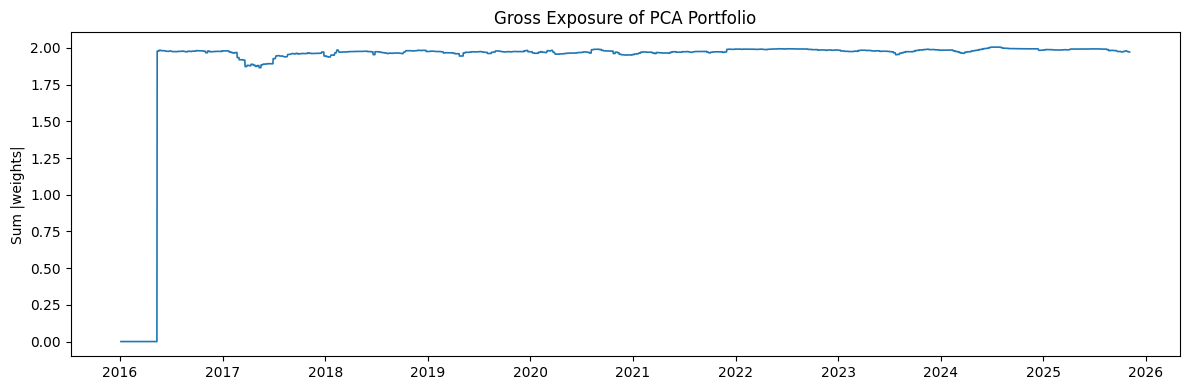

In [18]:
plt.figure(figsize=(12,4))
plt.plot(df_w.index, df_w.abs().sum(axis=1), linewidth=1.2)
plt.title("Gross Exposure of PCA Portfolio")
plt.ylabel("Sum |weights|")
plt.tight_layout()
plt.show()

PCA looks very stable. This might be enough to build a trading strategy around it. The variance is highly explained by the first principal component. I need to convert this into trading weights, the current loadings on the different expiries is based on the standardized returns, not actual returns. Therefore, I will need to scale the weights by the standard deviation of the fixed-term expiries and then propogate those weights into the actual instruments (not-fixed) based on their weight contribution to the fixed term exposure.  